# Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Establishing Connection and Importing data from MySQL

In [3]:
try:
    connection = mysql.connector.connect(
        host = 'localhost',
        user = 'root',
        password = 'admin',
        database = 'bitcoin_eda'
    )

    # Importing table into dataframe
    df = pd.read_sql("select * from bitcoin_data", connection)

    connection.close()
except mysql.connector.Error as err:
    print(f'Error: {err}')

C:\Users\Vivek_Karnakar\AppData\Local\Temp\ipykernel_29852\3582593725.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("select * from bitcoin_data", connection)


### Importing Data from CSV file instead of MySQL

In [ ]:
# Dataset CSV file
# df = pd.read_csv('Bitcoin Historical Data.csv')

In [5]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,24-03-2024,"67,211.9","64,036.5","67,587.8","63,812.9",65.59K,4.96%
1,23-03-2024,"64,037.8","63,785.6","65,972.4","63,074.9",35.11K,0.40%
2,22-03-2024,"63,785.5","65,501.5","66,633.3","62,328.3",72.43K,-2.62%
3,21-03-2024,"65,503.8","67,860.0","68,161.7","64,616.1",75.26K,-3.46%
4,20-03-2024,"67,854.0","62,046.8","68,029.5","60,850.9",133.53K,9.35%
...,...,...,...,...,...,...,...
4994,22-07-2010,0.1,0.1,0.1,0.1,2.16K,0.00%
4995,21-07-2010,0.1,0.1,0.1,0.1,0.58K,0.00%
4996,20-07-2010,0.1,0.1,0.1,0.1,0.26K,0.00%
4997,19-07-2010,0.1,0.1,0.1,0.1,0.57K,0.00%


## Cleaning or formatting the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4999 non-null   object
 1   Price     4999 non-null   object
 2   Open      4999 non-null   object
 3   High      4999 non-null   object
 4   Low       4999 non-null   object
 5   Vol.      4999 non-null   object
 6   Change %  4999 non-null   object
dtypes: object(7)
memory usage: 273.5+ KB


In [7]:
df['Date'].dtype

dtype('O')

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\Vivek_Karnakar\AppData\Local\Temp\ipykernel_29852\2394721818.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [9]:
df['Date'].dtype

dtype('<M8[ns]')

In [10]:
df['Price'].dtype

dtype('O')

In [12]:
# Function to convert all the string numbers into actual numbers
def convert_to_float(value):

    if isinstance(value, (float, np.floating)) or pd.isna(value):
        return value

    try:
        if isinstance(value, str):
            cleaned_value = value.replace(',', '')
            return float(cleaned_value)
        else:
            return float(value)

    except (ValueError, AttributeError, TypeError):
        return np.nan

In [13]:
df['Price'] = df['Price'].apply(convert_to_float)
df['Open'] = df['Open'].apply(convert_to_float)
df['High'] = df['High'].apply(convert_to_float)
df['Low'] = df['Low'].apply(convert_to_float)

In [14]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-24,67211.9,64036.5,67587.8,63812.9,65.59K,4.96%
1,2024-03-23,64037.8,63785.6,65972.4,63074.9,35.11K,0.40%
2,2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%
3,2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%
4,2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%


In [15]:
df.rename(columns = {'Vol.': 'Volumn'}, inplace = True)

In [16]:
df.rename(columns = {'Change %': 'Percent Change'}, inplace = True)

In [17]:
df['Volumn'] = df['Volumn'].astype(str)

In [18]:
# Function to clean the volumn column
def clean_vol(value):
    value = value.strip()
    value = value.upper()

    if 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000
    else:
        return np.nan

In [19]:
df['Volumn'] = df['Volumn'].apply(clean_vol)

In [20]:
df.isnull().sum()

Date              0
Price             0
Open              0
High              0
Low               0
Volumn            6
Percent Change    0
dtype: int64

In [21]:
df[df.isnull().any(axis=1)]

,Date,Price,Open,High,Low,Volumn,Percent Change
4656,2011-06-25,17.5,17.5,17.5,17.5,NaN,0.00%
4657,2011-06-24,17.5,17.5,17.5,17.5,NaN,0.00%
4658,2011-06-23,17.5,17.5,17.5,17.5,NaN,0.00%
4659,2011-06-22,17.5,17.5,17.5,17.5,NaN,0.00%
4660,2011-06-21,17.5,17.5,17.5,17.5,NaN,0.00%
4661,2011-06-20,17.5,17.5,17.5,17.5,NaN,0.00%


In [22]:
# Using backward fill to fill NA values
df['Volumn'].fillna(method = 'bfill', inplace = True)

C:\Users\Vivek_Karnakar\AppData\Local\Temp\ipykernel_29852\1623183907.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volumn'].fillna(method = 'bfill', inplace = True)
C:\Users\Vivek_Karnakar\AppData\Local\Temp\ipykernel_29852\1623183907.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volumn'].fillna(method = 'bfill', inplace = True)


In [23]:
df['Percent Change'].dtype

dtype('O')

In [24]:
def remove_percent(value):
    value = value.replace('%', '')
    return round(float(value), 2)

In [25]:
df['Percent Change'] = df['Percent Change'].apply(remove_percent)

In [26]:
df['Percent Change'].dtype

dtype('float64')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            4999 non-null   datetime64[ns]
 1   Price           4999 non-null   float64       
 2   Open            4999 non-null   float64       
 3   High            4999 non-null   float64       
 4   Low             4999 non-null   float64       
 5   Volumn          4999 non-null   float64       
 6   Percent Change  4999 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 273.5 KB


<h1>Perprocessing and Visualization</h1>

In [28]:
# Taking the data of year 2023
year_23 = df[df['Date'].dt.year == 2023]
year_23.shape

(365, 7)

In [29]:
year_23 = year_23[['Date', 'Price']]
year_23

,Date,Price
84,2023-12-31,42272.5
85,2023-12-30,42136.7
86,2023-12-29,42072.4
87,2023-12-28,42581.1
88,2023-12-27,43446.5
...,...,...
444,2023-01-05,16829.8
445,2023-01-04,16852.1
446,2023-01-03,16674.2
447,2023-01-02,16674.3


In [30]:
# Reversing the data
year_23_new = pd.DataFrame()
year_23_new['Date'] = year_23['Date'].iloc[::-1]
year_23_new['Price'] = year_23['Price'].iloc[::-1]

In [31]:
year_23_new.reset_index(drop = True, inplace = True)

In [32]:
year_23_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Price   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


### Outlier detection and treatment

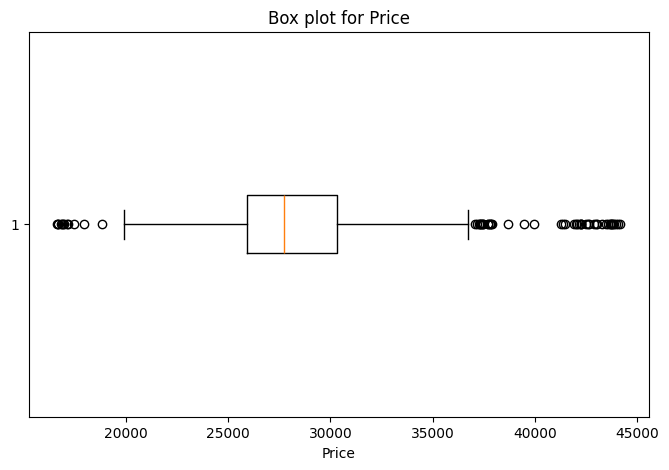

In [33]:
# Detecting outliers in price
plt.figure(figsize = (8, 5))
plt.boxplot(year_23_new['Price'], vert = False)
plt.title('Box plot for Price')
plt.xlabel('Price')

plt.show()

In [34]:
# Finding upper and lower bound for price
Q1 = year_23['Price'].quantile(0.25)
Q3 = year_23['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

outlier_df = year_23[(year_23['Price'] < lower_bound)]

outlier_df

,Date,Price
437,2023-01-12,18851.3
438,2023-01-11,17942.3
439,2023-01-10,17439.1
440,2023-01-09,17180.1
441,2023-01-08,17119.0
442,2023-01-07,16943.6
443,2023-01-06,16950.9
444,2023-01-05,16829.8
445,2023-01-04,16852.1
446,2023-01-03,16674.2


In [35]:
outlier_df.shape

(12, 2)

In [36]:
# As there are only 12 lower outliers present in the price column, we will replace them with lower bound.
# We will not be treating upper outlier because they are actual values that will be need for prediction

year_23['Price'] = np.where(year_23['Price'] < lower_bound, lower_bound, year_23['Price'])

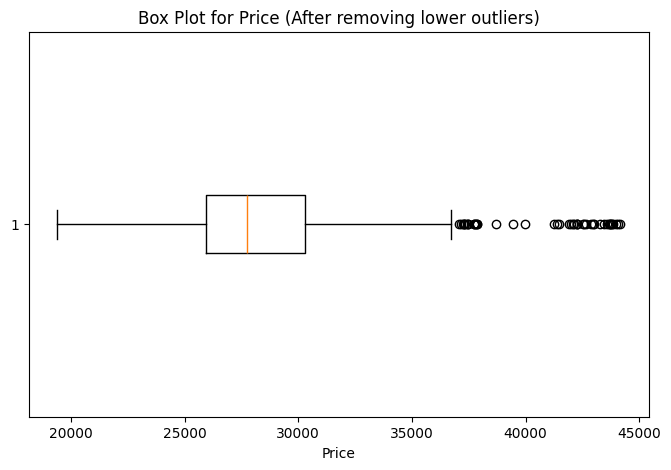

In [38]:
# Box polt of price after treating outliers
plt.figure(figsize = (8, 5))
plt.boxplot(year_23['Price'], vert = False)
plt.title('Box Plot for Price (After removing lower outliers)')
plt.xlabel('Price')

plt.show()

### Calculating Moving average

In [39]:
year_23_new

,Date,Price
0,2023-01-01,16618.4
1,2023-01-02,16674.3
2,2023-01-03,16674.2
3,2023-01-04,16852.1
4,2023-01-05,16829.8
...,...,...
360,2023-12-27,43446.5
361,2023-12-28,42581.1
362,2023-12-29,42072.4
363,2023-12-30,42136.7


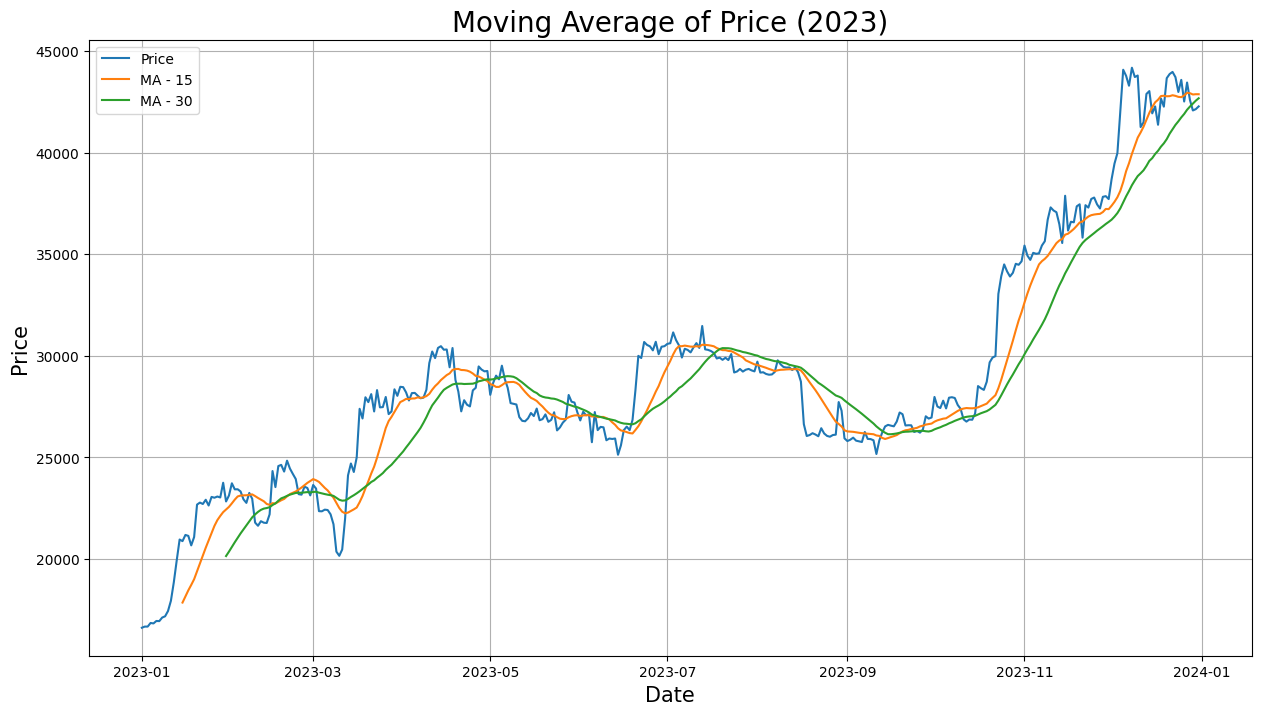

In [40]:
# Calculating moving average (window 15 and 30)
import matplotlib.pyplot as plt

year_23_new['MA_15'] = year_23_new['Price'].rolling(window = 15).mean()
year_23_new['MA_30'] = year_23_new['Price'].rolling(window = 30).mean()

plt.figure(figsize = (15, 8))
plt.plot(year_23_new['Date'], year_23_new['Price'], label = 'Price')
plt.plot(year_23_new['Date'], year_23_new['MA_15'], label = 'MA - 15')
plt.plot(year_23_new['Date'], year_23_new['MA_30'], label = 'MA - 30')
plt.grid()
plt.legend()
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.title('Moving Average of Price (2023)', fontsize = 20)
plt.show()

### Classical Decomposition

In [41]:
# Classical decomposition for price
decomposition_multiplicative = seasonal_decompose(year_23_new['Price'], model = 'multiplicative', period = 30)

In [42]:
trend_multiplicative = decomposition_multiplicative.trend
seasonal_multiplicative = decomposition_multiplicative.seasonal
residual_multiplicative = decomposition_multiplicative.resid

Text(0.5, 0.98, 'Classical Decomposition of Price (2023)')

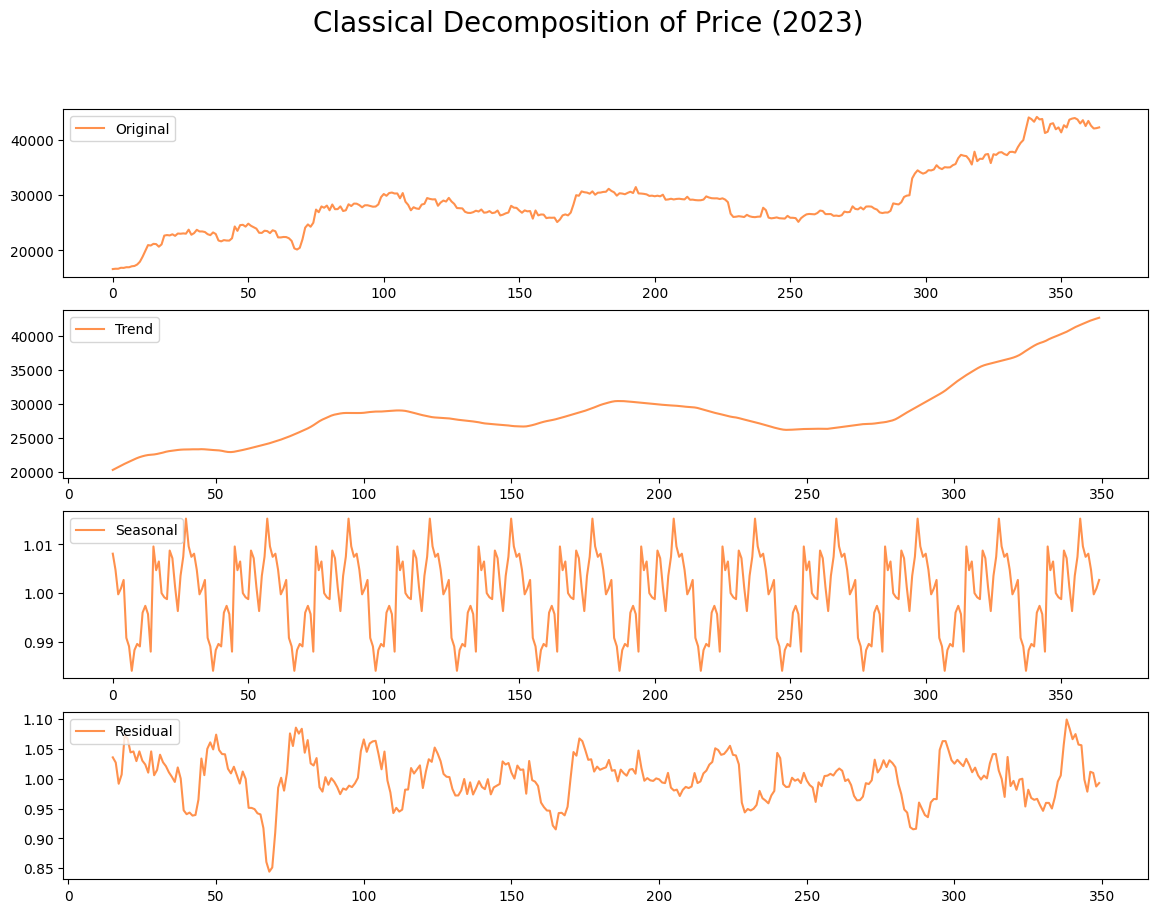

In [45]:
plt.figure(figsize = (14, 10))
plt.subplot(411)
plt.plot(year_23_new['Price'], label = 'Original', color = '#ff914d')
plt.legend(loc = 'upper left')
plt.subplot(412)
plt.plot(trend_multiplicative, label = 'Trend', color = '#ff914d')
plt.legend(loc = 'upper left')
plt.subplot(413)
plt.plot(seasonal_multiplicative, label = 'Seasonal', color = '#ff914d')
plt.legend(loc = 'upper left')
plt.subplot(414)
plt.plot(residual_multiplicative, label = 'Residual', color = '#ff914d')
plt.legend(loc = 'upper left')
plt.suptitle('Classical Decomposition of Price (2023)', fontsize = 20)

In [46]:
# Again taking the data of year 2023 for further code requirements
year_23 = df[df['Date'].dt.year == 2023]
year_23 = year_23[['Date', 'Price']]
year_23_new = pd.DataFrame()
year_23_new['Date'] = year_23['Date'].iloc[::-1]
year_23_new['Price'] = year_23['Price'].iloc[::-1]
year_23_new.reset_index(drop = True, inplace = True)

In [47]:
year_23_new

,Date,Price
0,2023-01-01,16618.4
1,2023-01-02,16674.3
2,2023-01-03,16674.2
3,2023-01-04,16852.1
4,2023-01-05,16829.8
...,...,...
360,2023-12-27,43446.5
361,2023-12-28,42581.1
362,2023-12-29,42072.4
363,2023-12-30,42136.7


### Stationarity

In [48]:
# Making Data Stationary
# Stationarity for univariate models only
# Perform the Augmented Dickey-Fuller Test
adf_test1 = adfuller(year_23_new['Price'])

print('ADF Test Result:')
print(f'ADF Statistics: {round(adf_test1[0], 3)}')
print(f'p-value: {round(adf_test1[1], 3)}')

ADF Test Result:
ADF Statistics: -0.856
p-value: 0.802


In [49]:
# Price column is not stationary so, we will apply differencing now.
year_23_new['Price_differenced'] = year_23_new['Price'].diff()

In [50]:
year_23_new.dropna(inplace = True)

In [51]:
adf_test1 = adfuller(year_23_new['Price_differenced'])

print('ADF Test Result:')
print(f'ADF Statistics: {round(adf_test1[0], 3)}')
print(f'p-value: {round(adf_test1[1], 3)}')

ADF Test Result:
ADF Statistics: -19.99
p-value: 0.0


In [52]:
# Now the price column has become stationary and we can build model on it.

# ACF & PACF Plot

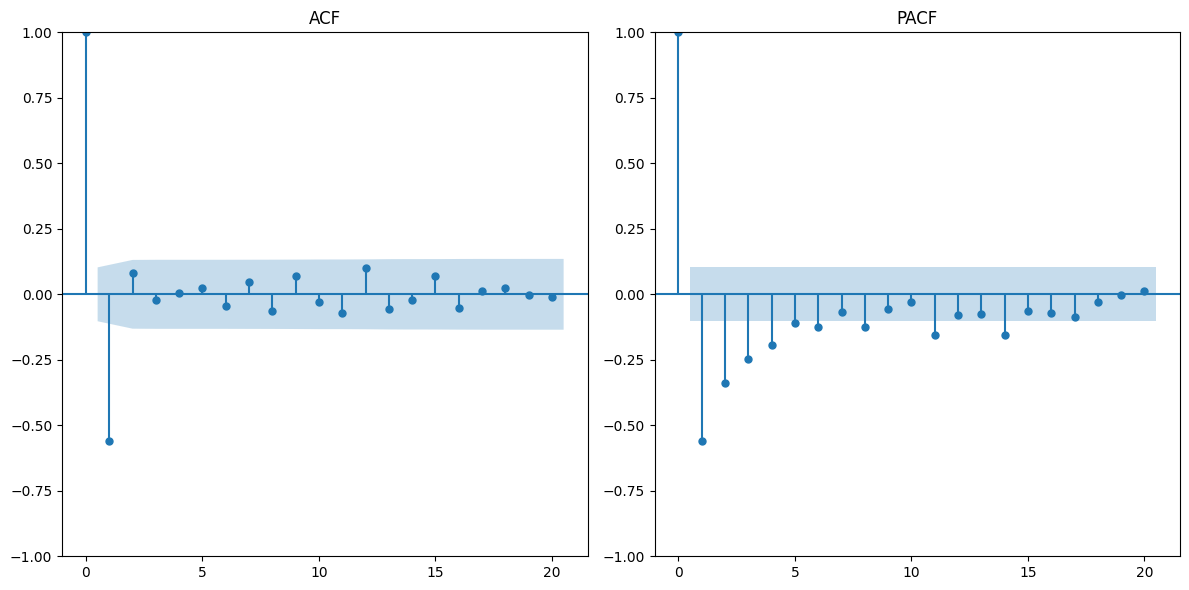

In [53]:
# ACF & PACF plot
plt.figure(figsize = (12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(year_23_new['Price_differenced'].diff().dropna(), ax = plt.gca(), lags = 20)
plt.title('ACF')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(year_23_new['Price_differenced'].diff().dropna(), ax = plt.gca(), lags = 20, method = 'ywm')
plt.title('PACF')

plt.tight_layout()
plt.show()

As there is a sharph cut off after lag 1 in ACF plot and a gradual decrease in PACF plot 
therefore, we will use MA model and ARIAM model.

We will be predicting 1 month of prices i.e Jan 2024

## Training and Testing data Split

In [54]:
# Training data :- price of bitcoin for the year 2023
train_data = year_23_new['Price_differenced']
train_data = train_data.values

# Testing data :- price of bitcoin for the month of january 2024
jan_2024_data = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2024-02-01')]
test_data = jan_2024_data['Price']
test_data = test_data.values

# MA model

In [55]:
# Fitting model
model = ARIMA(train_data, order = (0, 0, 1))
model_fit = model.fit()

# Forecasting
predictions = model_fit.forecast(steps = len(test_data))

In [56]:
predictions

array([67.681382  , 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562, 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562, 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562, 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562, 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562, 70.47829562, 70.47829562, 70.47829562, 70.47829562,
       70.47829562])

In [57]:
# Reverse the Differencing to Get Predictions in the Original Scale

last_original_value = year_23_new['Price'].iloc[-1]
original_predictions = np.zeros_like(predictions, dtype=float)
original_predictions[0] = predictions[0] + last_original_value

for i in range(1, len(predictions)):
    original_predictions[i] = predictions[i] + original_predictions[i - 1]

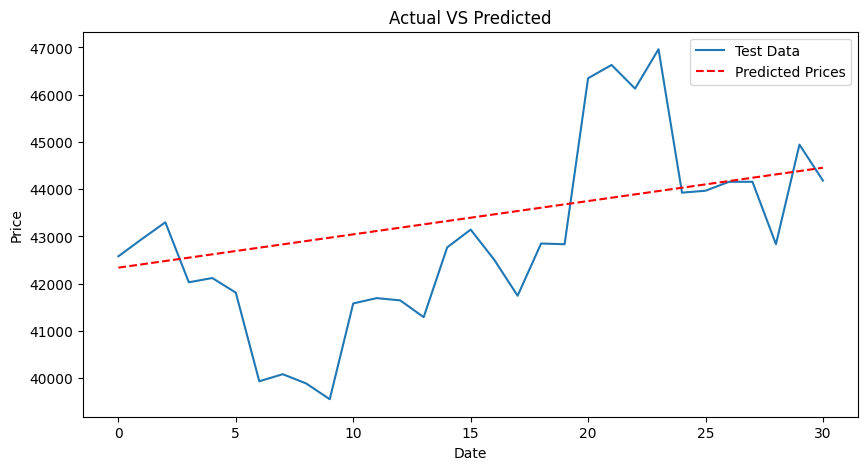

In [58]:
# Plot the actual VS predicted values
plt.figure(figsize = (10, 5))
plt.plot(test_data, label = 'Test Data')
plt.plot(original_predictions, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('Actual VS Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
rsme = np.sqrt(mean_squared_error(test_data, original_predictions))
print('Root Mean Squared Error (RMSE):', rsme)

Root Mean Squared Error (RMSE): 1666.1671985566472


# ARIMA Model

In [60]:
# Importing the model
from statsmodels.tsa.arima.model import ARIMA

# Performing grid search on ARIMA model
p = [1, 2, 3, 4, 5]
d = [0, 1, 2, 3]
q = [1, 2]
rmse = float('inf')
best_params = []

for p, q, d in itertools.product(p, q, d):
  model = ARIMA(train_data, order = (p, d, q))
  model_fit = model.fit()
  predictions = model_fit.forecast(steps = len(test_data))

  last_original_value = year_23_new['Price'].iloc[-1]
  original_predictions = np.zeros_like(predictions, dtype=float)
  original_predictions[0] = predictions[0] + last_original_value

  for i in range(1, len(predictions)):
    original_predictions[i] = predictions[i] + original_predictions[i - 1]

  new_rsme = np.sqrt(mean_squared_error(test_data, original_predictions))

  if new_rsme < rmse:
    rmse = new_rsme
    best_params = [p, d, q]

print(f'RMSE: {rmse}')
print(f'Best Parameters: {best_params}')

C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found

RMSE: 1584.183923208278
Best Parameters: [4, 2, 2]


C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
# Fitting model
model = ARIMA(train_data, order = (4, 2, 2))
model_fit = model.fit()

# Forecasting
predictions = model_fit.forecast(steps = len(test_data))

C:\Users\Vivek_Karnakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
# Reverse the Differencing to Get Predictions in the Original Scale
last_original_value = year_23_new['Price'].iloc[-1]
original_predictions = np.zeros_like(predictions, dtype=float)
original_predictions[0] = predictions[0] + last_original_value

for i in range(1, len(predictions)):
    original_predictions[i] = predictions[i] + original_predictions[i - 1]

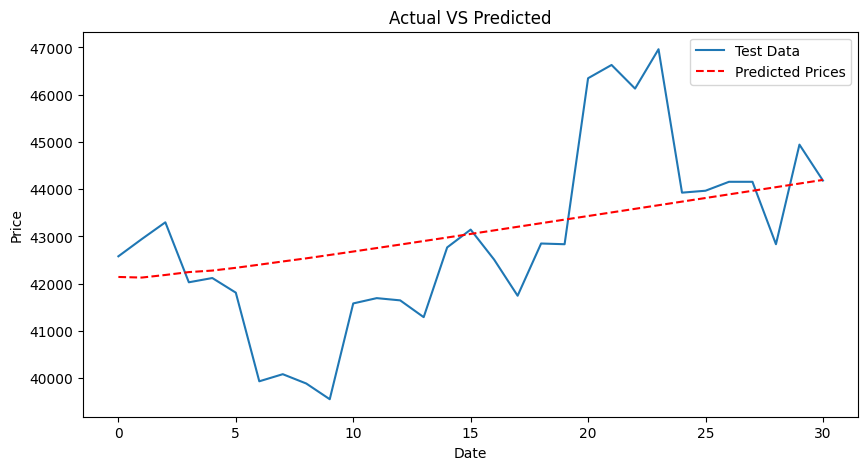

In [63]:
# Plot the actual VS predicted values
plt.figure(figsize = (10, 5))
plt.plot(test_data, label = 'Test Data')
plt.plot(original_predictions, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('Actual VS Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [64]:
rsme = np.sqrt(mean_squared_error(test_data, original_predictions))
print('Root Mean Squared Error (RMSE):', rsme)

Root Mean Squared Error (RMSE): 1584.183923208278


# Conclusion
#### ARIMA model has performed the best for predicting prices for bitcoin for the month on Jan-2024.
#### The best parameters used by ARIMA model are p = 4, d = 2, q = 2.
#### We have an RMSE of 1584.

In [ ]:
# ----------------------------------------- Below code is for my personal use (Not part of the project) --------------------------------------

# Writing dataframe to MySQL

In [ ]:
from sqlalchemy import create_engine

In [ ]:
host = '127.0.0.1'
user = 'root'
password = 'admin'
database = 'bitcoin_eda'
port = '3306'

In [ ]:
# MySQL engine
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}")

In [ ]:
# Saving dataframe to MySQL
try:
    df.to_sql('cleaned_bitcoin_data', engine, if_exists='replace', index=False)
    print('Dataframe saved to MySQL database.')

except Exception as e:
    print(f"An error occurred: {e}")

Dataframe saved to MySQL database.
